# Random Walk

Let's suppose we have a random walk process defined by
$$
x(t+1) = x(t) + 2 \varepsilon - 1, \; \; \; \; \varepsilon \sim \mathrm{Bernoulli}(p)
$$
where $p$ is the probability of doing a step forward.

In this notebook, we create some synthetic data for a value of $p$ and we try to recover it through inference.

In [1]:
from birds.models.random_walk import RandomWalk
from birds.calibrator import Calibrator

import torch
import matplotlib.pyplot as plt
import pandas as pd

## Generating synthetic data

In [2]:
rw = RandomWalk(n_timesteps=100)

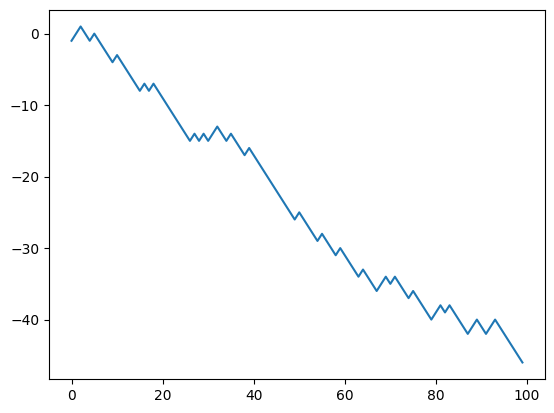

In [3]:
true_data = rw(torch.tensor([0.25])) 
#true_data[0] += torch.normal(torch.zeros(100), 5 * torch.ones(100))

plt.plot(true_data[0].numpy())

## Defining the calibrator

Here we assume that the posterior distribution has a gaussian form, so we need to implement a parametrized gaussian that contains the `sample`, `rsample`, and `log_prob` methods:

In [4]:
class TrainableGaussian(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Parameter(0.5 * torch.ones(1))
        self.sigma = torch.nn.Parameter(0.1 * torch.ones(1))

    def log_prob(self, x):
        sigma = torch.clip(self.sigma, min=1e-3)
        return torch.distributions.Normal(self.mu, sigma).log_prob(x)

    def rsample(self, x):
        sigma = torch.clip(self.sigma, min=1e-3)
        return torch.distributions.Normal(self.mu, sigma).rsample(x)

    def sample(self, x):
        sigma = torch.clip(self.sigma, min=1e-3)
        return torch.distributions.Normal(self.mu, sigma).sample(x)


Notice that we clip $\sigma$ to prevent unphysical values. All we need to do know is to specify a prior and initialize the calibrator. Other optional arguments are described here:

In [5]:
?Calibrator

Init signature:
Calibrator(
    model,
    prior,
    posterior_estimator,
    data,
    w=0.0,
    gradient_clipping_norm=inf,
    forecast_loss=None,
    optimizer=None,
    n_samples_per_epoch=5,
    n_samples_regularisation=10000,
    diff_mode='reverse',
    device='cpu',
    progress_bar=True,
)
Docstring:      <no docstring>
Init docstring:
Class that handles the training of the posterior_estimator given the model, data, and prior.

Arguments:
    model (torch.nn.Module): The simulator model.
    prior (torch.distributions.Distribution): The prior distribution.
    posterior_estimator (torch.distributions.Distribution): The variational distribution that approximates the generalised posterior.
    data (List[torch.Tensor]): The observed data to calibrate against. It must be given as a list of tensors that matches the output of the model.
    w (float): The weight of the regularisation loss in the total loss.
    gradient_clipping_norm (float): The norm to which the gradients are 

In [6]:
posterior_estimator = TrainableGaussian()
prior = torch.distributions.Normal(0, 1)
optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-2)

calibrator = Calibrator(model = rw, posterior_estimator=posterior_estimator, prior=prior, data=true_data, optimizer=optimizer, w = 1)

In [7]:
# we can now train the estimator for a 100 epochs
losses, best_model = calibrator.run(100, max_epochs_without_improvement=20)

 67%|██████████████████████▊           | 67/100 [00:00<00:00, 221.20it/s, Forecast=29.2, Reg.=6.43, total=35.7, best loss=tensor(19.1274, grad_fn=<AddBackward0>), epochs since improv.=20]


The model stops when it hits a certain amount of epochs without improvement.
The run function returns the loss per epoch as well as the best model weights.
Let's have a look at the loss first:

In [8]:
df = pd.DataFrame(losses)
df.head()

,total,forecast,regularisation
0,744.536499,742.608032,1.928477
1,880.631958,878.799988,1.831954
2,690.402161,688.671997,1.730189
3,1183.870117,1182.095947,1.774148
4,854.379395,852.544067,1.835337


<Axes: >

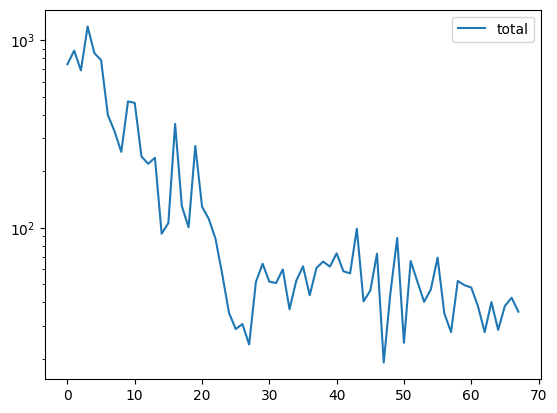

In [9]:
df.plot(y="total", logy=True)

In [10]:
# We can now load the best model
posterior_estimator.load_state_dict(best_model)

<All keys matched successfully>

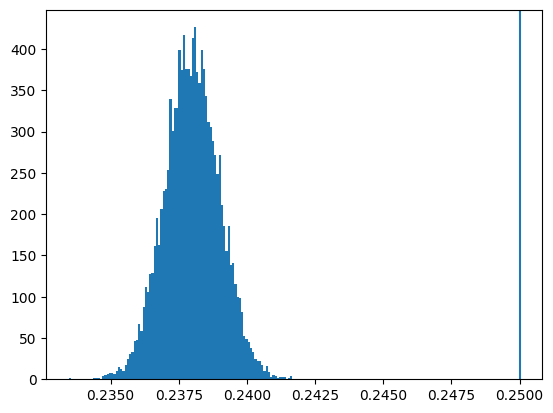

In [11]:
# and plot the posterior
samples = posterior_estimator.sample((10000,)).flatten().cpu()
plt.hist(samples, density=True, bins=100);
plt.axvline(0.25, label = "true value")

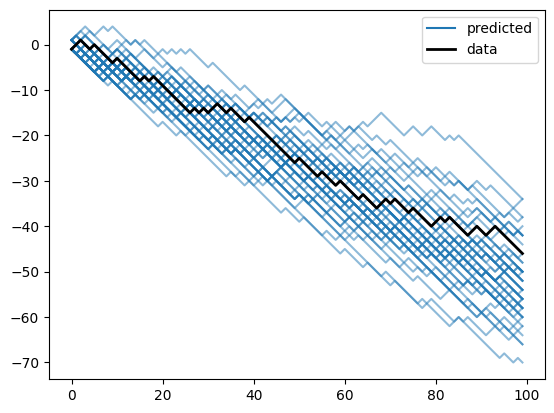

In [12]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(50):
    sim_rw = rw(posterior_estimator.sample((1,)))[0].numpy()
    ax.plot(sim_rw, color = "C0", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data")

ax.legend()